# Where is the Most Isolated Airport in the World?
A little data analysis to answer the question of where is the most isolated airport in the world.

What is a *airport*? Great question. Here I consider it to be an airport to be more than just a dirt airstrip. It should be capable of handling commerical air traffic using common airlners. So that implies the airport must have at least one paved runway capable of handling a fifty seat turbo-prop airline (my definition). So for an ATR-42, that leads to a minimum rwy length of approximately 1,000 metres or 3,280 feet.

## 1. Data Collection
Using [OurAirports](https://ourairports.com/) data, which is open-source, appears extensive, and regulary updated.

In [1]:
import urllib.request
import pathlib
import numpy as np
import pandas as pd
import modules

# Set up file names, file path, url and download data
fns = ['airports.csv', 'runways.csv', 'countries.csv', 'regions.csv']
data_dir = '../data/'
url_base = 'https://ourairports.com/data/'

for fn in fns:
    fp = pathlib.Path(data_dir + fn)
    url = url_base + fn
    req = urllib.request.Request(url)

    # Try catch for legacy ssl session
    try:
        response = urllib.request.urlopen(req)
        sc = response.status
        data = response

    except urllib.error.URLError as e:
        print(f"{e.reason} for {url}")
        print("Trying get_legacy_session()")

        with modules.get_legacy_session() as s:
            response = s.get(url, stream=True)
            sc = response.status_code
            data = response.raw

    if sc == 200:
        print(f"Successfully downloaded data for {url}")
    else:
        print(f"Issues downloading data for {url}")

    # Now save data
    fp = pathlib.Path(data_dir + fn)
    with open(fp, "wb") as f:
        f.write(data.read())


Successfully downloaded data for https://ourairports.com/data/airports.csv
Successfully downloaded data for https://ourairports.com/data/runways.csv
Successfully downloaded data for https://ourairports.com/data/countries.csv
Successfully downloaded data for https://ourairports.com/data/regions.csv


In [2]:
# Read in data for airports
fp = pathlib.Path(data_dir + fns[0])
df_airports = pd.read_csv(fp, index_col='id')

keep_cols = ['id',
             'type',
             'name',
             'latitude_deg',
             'longitude_deg',
             'elevation_ft',
             'continent',
             'iso_country',
             'iso_region',
             'scheduled_service',
             'iata_code']
df_airports = df_airports.loc[:, df_airports.columns.isin(keep_cols)]

col_rn = {'name': 'airport_name'}
df_airports.rename(columns=col_rn, inplace=True)
df_airports.rename_axis('airport_id', inplace=True)


In [3]:
# Read in data for runways
fp = pathlib.Path(data_dir + fns[1])
df_rwys = pd.read_csv(fp, index_col='id')

keep_cols = ['id',
             'airport_ref',
             'length_ft',
             'width_ft',
             'surface',
             'closed']
df_rwys = df_rwys.loc[:, df_rwys.columns.isin(keep_cols)]

col_rn = {'airport_ref': 'airport_id'}
df_rwys.rename(columns=col_rn, inplace=True)
df_rwys.rename_axis('rwy_id', inplace=True)


In [4]:
# Read in data for countries
fp = pathlib.Path(data_dir + fns[2])
df_countries = pd.read_csv(fp, index_col='code')

keep_cols = ['code',
             'name',
             'continent']
df_countries = df_countries.loc[:, df_countries.columns.isin(keep_cols)]

col_rn = {'name': 'country_name'}
df_countries.rename(columns=col_rn, inplace=True)
df_countries.rename_axis('iso_country', inplace=True)


In [5]:
# Read in data for regions or sub-country areas
fp = pathlib.Path(data_dir + fns[3])
df_regions = pd.read_csv(fp, index_col='code')
keep_cols = ['code',
             'name',
             'continent',
             'iso_country']
df_regions = df_regions.loc[:, df_regions.columns.isin(keep_cols)]

col_rn = {'name': 'region_name'}
df_regions.rename(columns=col_rn, inplace=True)
df_regions.rename_axis('iso_region', inplace=True)


#### Filter out airport data that does not fit definition of a land-based airport

In [6]:
# Drop heliports, seaplane bases, balloon ports and closed airports
drop_types = ['heliport', 'seaplane_base', 'balloonport', 'closed']
df_airports = df_airports.loc[~(df_airports['type'].isin(drop_types)), :]

#### Clean up and consolidate runway surface descriptions

In [7]:
df_rwys['surface'] = df_rwys['surface'].str.lower()

# Fill NAs
df_rwys.loc[df_rwys['surface'].isna(), 'surface'] = 'unknown'

# Append '_other' to then use later for replacement any surfaces we don't
# expliairport change
df_rwys['surface'] = df_rwys['surface'].apply(lambda x: f"{x}_other")

# Paved surfaces
pat = r'asp|con|bit|met|asfalt|tar|cement|paved|ashpalt|pavement|blacktop' + \
    '|apsh|paving|sealed|asb|mac'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'paved'

# Grass surfaces
pat = r'turf|grass|grs|gras|graas|sod'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'grass'

# Dirt surfaces
pat = r'dirt|gvl|grvl|gre|gravel|earth|san|wood|grv|cla|ground|mat|rock|' + \
    'coral|unpaved|graded|aluminum|soil|steel|alum|grav|eartth|unsealed|' + \
    'lakebed|loam|chip|oil|salt|silt|grain|mud|piç|brick|hard|dust|gra|' + \
    'zahorra|caliche'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'dirt'

# Water
pat = r'wat'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'water'

# Ice
pat = r'ice|sno'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'ice'

# Pads
pat = r'roof|pad'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'pad'

# Unknown
pat = r'unk'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'unknown'

# Everything else is other
pat = r'other'
df_rwys.loc[df_rwys['surface'].str.contains(
    pat, case=False), 'surface'] = 'other'


#### Filter out runway data similiar to airports above

In [8]:
# Drop closed runways, and any runways with surfaces made of water, helipads or water
drop_surfaces = ['water', 'pad', 'unknown']
df_rwys = df_rwys.loc[~df_rwys['surface'].isin(drop_surfaces), :]
df_rwys = df_rwys.loc[df_rwys['closed'] == 0, :]

# Drop very short runways
min_rwy_len = 500  # feet
df_rwys = df_rwys.loc[df_rwys['length_ft'] > min_rwy_len, :]


#### Formatting helpers

In [9]:
from IPython.display import display

print_n = 10

# For setting column widths
max_airport_name_len = df_airports['airport_name'].apply(
    lambda x: len(str(x))).max()
max_country_name_len = df_countries['country_name'].apply(
    lambda x: len(str(x))).max()

# Formats
text_col_names = r"name"
text_cells_fmt = {'text-align': 'left'}
airport_name_w = {'width': f'{max_airport_name_len/4}em'}
country_name_w = {'width': f'{max_country_name_len/4}em'}


def display_df(ddf, df_caption):
    # Quick function to display formatted data frame
    display(
        ddf.style
        .format(thousands=",", precision=0)
        .set_caption(df_caption)
        .set_properties(
            subset=ddf.columns[ddf.columns.str.contains(text_col_names)],
            **text_cells_fmt)
        .set_properties(
            subset=ddf.columns[ddf.columns.str.contains("Airport")],
            **airport_name_w)
        .set_properties(
            subset=ddf.columns[ddf.columns.str.contains("Country")],
            **country_name_w)
        .set_table_styles(
            [dict(selector='th', props=[('text-align', 'left')]),
             dict(selector='caption',
                  props=[('text-align', 'left'),
                         ('font-size', '125%'),
                         ('line-height', '2.0')])])
        .hide(axis='index')
    )

### 1.1 Some Quick Data Demographics

In [10]:
# Add the country and region data to the airport data
drop_cols = ['continent']
dfac = df_airports.join(
    df_countries.loc[:, ~df_countries.columns.isin(drop_cols)],
    on='iso_country')

drop_cols = ['iso_country', 'continent']
dfac = dfac.join(
    df_regions.loc[:, ~df_regions.columns.isin(drop_cols)],
    on='iso_region')

# And add airport, country and region data to the runway data
df = df_rwys.join(dfac, on='airport_id', how='inner')


#### Total number of runways and airports in the data

In [11]:
from IPython.display import Markdown

disp_str = f"The data contains {len(df_airports):,.0f} airports " +\
    f"with {len(df_rwys):,.0f} runways"
display(Markdown(disp_str))


The data contains 44,541 airports with 34,107 runways

#### Airports with the most runways

In [12]:
print_cols = ['airport_name',
              'country_name',
              'region_name',
              'scheduled_service',
              'iata_code',
              'rwy_count',
              'paved',
              'dirt',
              'ice',
              'other']

print_cols_rn = {'airport_name': 'Airport Name',
                 'country_name': 'Country Name',
                 'region_name': 'Region Name',
                 'scheduled_service': 'Scheduled Services',
                 'iata_code': 'IATA Code',
                 'rwy_count': 'Number of Runways',
                 'paved': 'Paved Runways',
                 'dirt': 'Dirt Runways',
                 'ice': 'Ice Runways',
                 'other': 'Other Surface Runways'}

table_caption = "Airports with the most runways"
df_rwyc = df.groupby(['airport_id', 'surface'])['length_ft']\
    .count()\
    .to_frame('rwy_count')\
    .pivot_table(values='rwy_count',
                 index='airport_id',
                 columns='surface',
                 fill_value=0,
                 sort=False)

df_rwyc['rwy_count'] = df_rwyc.sum(axis=1)
df_rwyc = df_rwyc.join(dfac).sort_values('rwy_count', ascending=False)
display_df(df_rwyc[print_cols]
           .rename(columns=print_cols_rn)
           .fillna('')
           .head(print_n),
           table_caption)


Airport Name,Country Name,Region Name,Scheduled Services,IATA Code,Number of Runways,Paved Runways,Dirt Runways,Ice Runways,Other Surface Runways
Chicago O'Hare International Airport,United States,Illinois,yes,ORD,8,8,0,0,0
Spencer Nolf Airport,United States,Florida,no,,8,8,0,0,0
Dallas Fort Worth International Airport,United States,Texas,yes,DFW,7,7,0,0,0
Terlet Glider Field,Netherlands,Gelderland,no,,6,0,6,0,0
Denver International Airport,United States,Colorado,yes,DEN,6,6,0,0,0
Amsterdam Airport Schiphol,Netherlands,Noord-Holland,yes,AMS,6,6,0,0,0
Detroit Metropolitan Wayne County Airport,United States,Michigan,yes,DTW,6,4,0,0,2
Logan International Airport,United States,Massachusetts,yes,BOS,6,6,0,0,0
Fort Stockton Pecos County Airport,United States,Texas,no,FST,5,2,3,0,0
Oakey Army Aviation Centre,Australia,Queensland,yes,OKY,5,5,0,0,0


#### Airports with the longest runways

In [13]:
print_cols = ['airport_name',
              'country_name',
              'region_name',
              'scheduled_service',
              'iata_code',
              'length_ft',
              'width_ft',
              'surface',
              ]

print_cols_rn = {'airport_name': 'Airport Name',
                 'country_name': 'Country Name',
                 'region_name': 'Region Name',
                 'scheduled_service': 'Scheduled Services',
                 'iata_code': 'IATA Code',
                 'length_ft': 'Length (ft)',
                 'width_ft': 'Width (ft)',
                 'surface': 'Runway Surface',
                 }

table_caption = "Airports with the longest runways"

df_rwyl = df.groupby(['airport_id'])[
    'length_ft'].idxmax().to_frame('rwy_id')
df_rwyl = df_rwyl.join(dfac)
df_rwyl = df_rwyl.join(df_rwys, on='rwy_id',
                       how='left').sort_values('length_ft', ascending=False)

display_df(df_rwyl[print_cols]
           .rename(columns=print_cols_rn)
           .fillna('')
           .head(print_n),
           table_caption)


Airport Name,Country Name,Region Name,Scheduled Services,IATA Code,Length (ft),Width (ft),Runway Surface
Xigaze Peace Airport / Shigatse Air Base,China,Tibet Autonomous Region,yes,RKZ,"16,404",197,paved
Ulyanovsk East Airport,Russia,Ulyanovsk Oblast,yes,ULY,"16,404",323,paved
Pierre Van Ryneveld Airport,South Africa,Northern Cape,yes,UTN,"16,076",197,paved
Denver International Airport,United States,Colorado,yes,DEN,"16,000",200,paved
Hamad International Airport,Qatar,Ad-Dawhah Municipality,yes,DOH,"15,912",197,paved
Golmud Airport,China,Qinghai Province,yes,GOQ,"15,748",160,paved
Erbil International Airport,Iraq,Arbil Governorate,yes,EBL,"15,748",246,paved
Robert Gabriel Mugabe International Airport,Zimbabwe,Harare Metropolitan Province,yes,HRE,"15,502",151,paved
Mmabatho International Airport,South Africa,North-West,yes,MBD,"15,157",148,paved
Zhukovsky International Airport,Russia,Moscow Oblast,yes,ZIA,"15,092",230,paved


#### Airports with the widest runways

In [14]:
table_caption = "Airports with the widest runways"

df_rwyw = df.groupby(['airport_id'])[
    'width_ft'].idxmax().to_frame('rwy_id')
df_rwyw = df_rwyw.join(dfac)
df_rwyw = df_rwyw.join(df_rwys, on='rwy_id',
                       how='left').sort_values('width_ft', ascending=False)

display_df(df_rwyw[print_cols]
           .rename(columns=print_cols_rn)
           .fillna('')
           .head(print_n),
           table_caption)


Airport Name,Country Name,Region Name,Scheduled Services,IATA Code,Length (ft),Width (ft),Runway Surface
Ridgeland-Claude Dean Airport,United States,South Carolina,no,,"4,200","7,075",paved
Aeródromo Municipal de Ponte de Sor,Portugal,Portalegre District,no,,"5,906","5,906",paved
Stapelburg Airfield,Germany,Lower Saxony,no,,"2,625","2,625",dirt
Ultra Flight Airpark,United States,Missouri,no,,"1,500","1,500",dirt
Dirt Dobber's Grass Strip,United States,North Carolina,no,,"1,600","1,000",dirt
Zmeyevo Airfield,Russia,Tver Oblast,no,,"2,789",984,dirt
Őcsény Airfield,Hungary,Tolna County,no,,"5,249",984,dirt
Terlet Glider Field,Netherlands,Gelderland,no,,"4,500",910,dirt
Flying 'K' Ranch Ultralightport,United States,Texas,no,,910,910,dirt
Rothera Research Station,Antarctica,(unassigned),no,,"2,950",900,dirt


#### A few simple histograms of the data
First set up the default chart styles and themes

In [15]:
import seaborn as sns
sns.set_theme(style='white', palette='dark')


Now look at count of ruwnays by length

In [16]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from datetime import datetime

today_date = datetime.today().strftime("%Y-%m-%d")

bins = 30


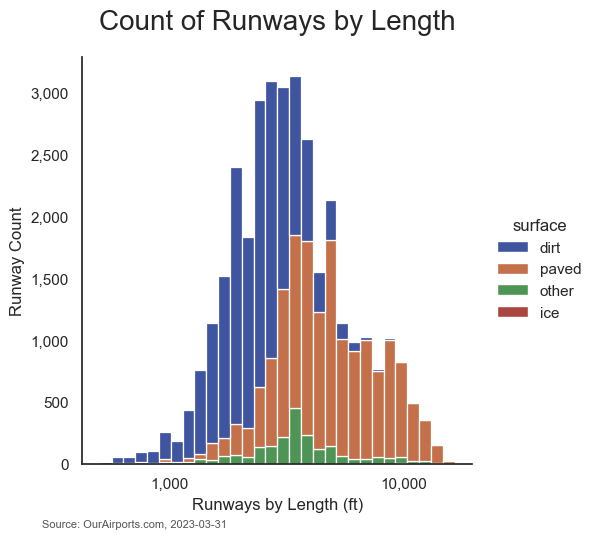

In [17]:

fg = sns.displot(
    data=df_rwys,
    x='length_ft',
    hue='surface',
    bins=bins,
    multiple='stack',
    log_scale=True,
    edgecolor=None,
)

fg.set_axis_labels(
    "Runways by Length (ft)",
    "Runway Count")


def xlbl_fmt(x, pos):
    # Format x axis tick labels
    return f"{x:,.0f}"


def ylbl_fmt(x, pos):
    # Format y axis tick labels
    return f"{x:,.0f}"


plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(xlbl_fmt))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(ylbl_fmt))

plt.gca().set_title("Count of Runways by Length",
                    fontdict={'fontsize': '20', 'fontweight': '3'},
                    pad=20)
_ = plt.gca().annotate("Source: OurAirports.com, "+today_date,
                       xy=(0.07, .04),
                       xycoords='figure fraction',
                       horizontalalignment='left',
                       verticalalignment='top',
                       fontsize=8,
                       color='#555555')


Histogram by runway length instead of just number of

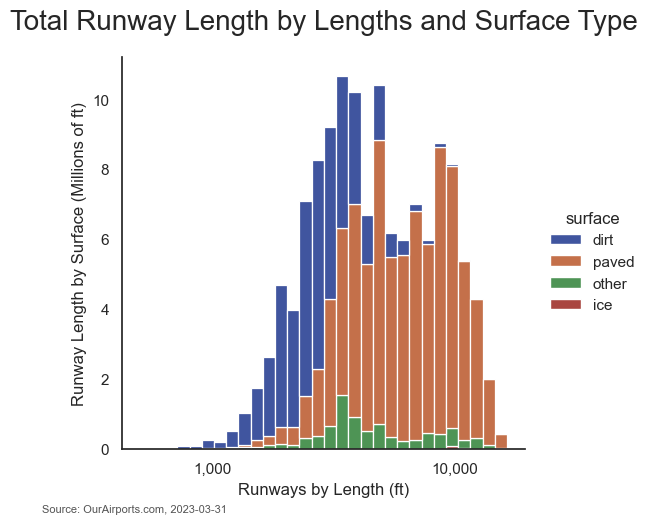

In [18]:
fg = sns.displot(df_rwys,
                 x='length_ft',
                 hue='surface',
                 weights='length_ft',
                 log_scale=True,
                 bins=bins,
                 multiple='stack')

fg.set_axis_labels(
    "Runways by Length (ft)",
    "Runway Length by Surface (Millions of ft)")


def xlbl_fmt(x, pos):
    # Format x axis tick labels
    return f"{x:,.0f}"


def ylbl_fmt(x, pos):
    # Format y axis tick labels
    return f"{x*1e-6:,.0f}"


plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(xlbl_fmt))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(ylbl_fmt))

plt.gca().set_title("Total Runway Length by Lengths and Surface Type",
                    fontdict={'fontsize': '20', 'fontweight': '3'},
                    pad=20)
_ = plt.gca().annotate("Source: OurAirports.com, "+today_date,
                       xy=(0.07, .04),
                       xycoords='figure fraction',
                       horizontalalignment='left',
                       verticalalignment='top',
                       fontsize=8,
                       color='#555555')


#### And quickly mapping the data

In [19]:
# import matplotlib as mpl
import matplotlib.colors as mplcolors
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Coordinate reference systems
wgs84_proj = 'EPSG:4326'  # WGS84 projection, typical lat lon style
rob_proj = 'ESRI:54030'  # Robinson projection, used for our map

# Setting up the base world map
world_fc = 'whitesmoke'  # base color
gpd_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gpd_world.to_crs(rob_proj, inplace=True)


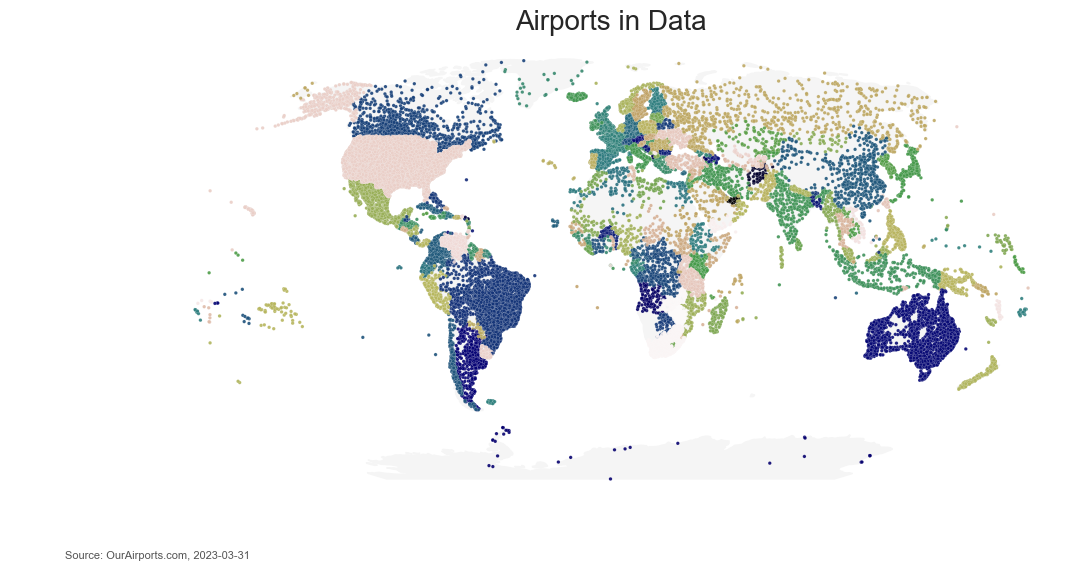

In [20]:
fig, ax = plt.subplots(figsize=(13, 6))
gpd_world.plot(ax=ax, color=world_fc, edgecolor=world_fc)

# Setting up the airport data and geometries
gdfa = gpd.GeoDataFrame(
    df_airports, geometry=gpd.points_from_xy(
        df_airports['longitude_deg'], df_airports['latitude_deg']), crs=wgs84_proj)
gdfa.to_crs(rob_proj, inplace=True)

# Plotting the airports
gdfa.plot(
    column='iso_country',
    ax=ax,
    marker='o',
    markersize=6,
    alpha=0.9,
    cmap='gist_earth',
    linewidth=0.1,
    edgecolor=mplcolors.colorConverter.to_rgba('white', alpha=.99),
)

# Formatting the plot
ax.set_axis_off()
ax.set_title("Airports in Data",
             fontdict={'fontsize': '20', 'fontweight': '3'})
_ = ax.annotate("Source: OurAirports.com, "+today_date,
                xy=(0.05, .03),
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=8,
                color='#555555')


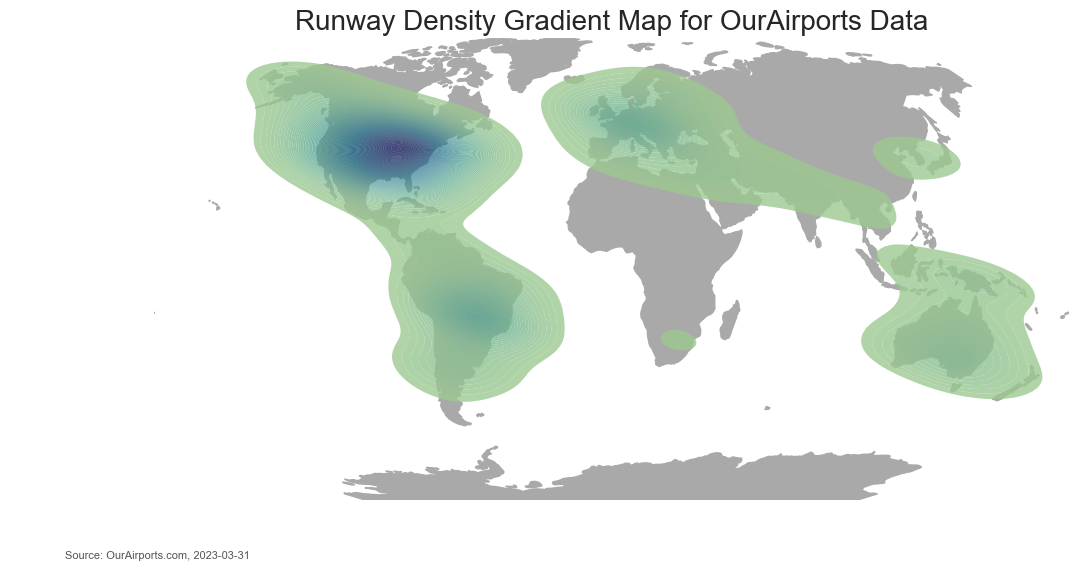

In [21]:
import scipy

# Set up the base map
fig, ax = plt.subplots(figsize=(13, 6))

world_fc_dark = 'darkgrey'
gpd_world.plot(ax=ax, color=world_fc_dark, edgecolor=world_fc_dark)
axis = gpd_world.total_bounds

# Set up the data frame to use
df_hm = df_rwyc.loc[:, ['latitude_deg', 'longitude_deg', 'rwy_count']]
df_hm = gpd.GeoDataFrame(
    df_hm,
    geometry=gpd.points_from_xy(df_hm['longitude_deg'], df_hm['latitude_deg']),
    crs=wgs84_proj)
df_hm.to_crs(crs=rob_proj, inplace=True)

# Get the lat and lon using the new coordinate reference system
df_hm['lon_gm'] = df_hm.geometry.x
df_hm['lat_gm'] = df_hm.geometry.y

# Calculate the KDE
data = np.c_[df_hm.lon_gm, df_hm.lat_gm]
kde = scipy.stats.gaussian_kde(
    data.T, bw_method='scott', weights=df_hm.rwy_count)
data_std = data.std(axis=0, ddof=1)
bw_x = getattr(kde, 'scotts_factor')() * data_std[0]
bw_y = getattr(kde, 'scotts_factor')() * data_std[1]
grid_x = grid_y = 150
x_support = sns.utils._kde_support(
    data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = sns.utils._kde_support(
    data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot the countor map
cset = plt.contourf(
    xx, yy, levels,
    100,  # n_levels
    cmap='crest',
    antialiased=True,  # avoids lines on the contours to some extent
    alpha=0.80,
)

# Hide lowest N levels
hide_n_lvls = 2
for i in range(0, hide_n_lvls):
    cset.collections[i].set_alpha(0)

# Formatting the plot
ax.set_axis_off()
ax.set_title("Runway Density Gradient Map for OurAirports Data",
             fontdict={'fontsize': '20', 'fontweight': '3'})
_ = ax.annotate("Source: OurAirports.com, "+today_date,
                xy=(0.05, .03),
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=8,
                color='#555555')


So peak in USA and Europe.

## 2 Looking at Data for Only Airports Capable of Commercial Operations

In [22]:
min_runway_len = 3280  # feet
rwy_surfaces = ['paved']
df_rwys_comm = df_rwys.loc[(df_rwys['length_ft'] >= min_rwy_len)
                           & (df_rwys['surface'].isin(rwy_surfaces)), :]

df_airpts_comm = dfac[dfac.index.isin(df_rwys_comm['airport_id'].unique())]
df_airpts_comm = df_airpts_comm.rename(
    columns={'latitude_deg': 'lat',
             'longitude_deg': 'lon'})


In [23]:
# Selection only a subset of data while debugging / initial coding
# df_airpts_comm = df_airpts_comm.iloc[:5000, :]


#### Generate all unique pairs of airports

In [24]:
def fmt_td(td):
    # Custom formatting of time delta objects

    str_out = ""
    secs = 0
    
    # if hasattr(td, 'weeks'):
    #     str_out += f"{td.weeks} weeks "
    # if hasattr(td, 'days'):
    #     if td.days > 0:
    #         str_out += f"{td.days} days "
    # if hasattr(td, 'hours'):
    #     str_out += f"{td.hours} hours "
    # if hasattr(td, 'minutes'):
    #     str_out += f"{td.minutes} minutes "
    if hasattr(td, 'seconds'):
        secs += td.seconds
    if hasattr(td, 'milliseconds'):
        secs += td.milliseconds * 1e-3
    if hasattr(td, 'microseconds'):
        secs += td.microseconds * 1e-6
    
    # str_out += f"{secs:.4f} seconds"
    
    return fmt_ts(secs)

def fmt_ts(time_sec):
    secs_in_min = 60
    time_str = f"{max(time_sec % secs_in_min, 0):,.4f} seconds"
    
    time_min = (time_sec - time_sec % secs_in_min) / secs_in_min
    if time_min > 0:
        mins_in_hr = 60
        time_str = f"{max(time_min % mins_in_hr, 0):,.0f} minutes " + time_str
        
        time_hr = (time_min - time_min % mins_in_hr) / mins_in_hr
        if time_hr > 0:
            hrs_in_day = 24
            time_str = f"{max(time_hr % hrs_in_day, 0):,.0f} hours " + time_str

            time_dys = (time_hr - time_hr % hrs_in_day) / hrs_in_day
            if time_dys > 0:
                time_str = f"{time_dys:,.0f} days " + time_str
    
    return time_str

In [25]:
import time
import datetime
from itertools import combinations
import math

disp_str = f"Generating {math.comb(len(df_airpts_comm), 2):,.0f}" + \
    " combinations; this may take a while"
display(Markdown(disp_str))

tic = time.perf_counter()

dist_pairs = pd.DataFrame(
    list(combinations(df_airpts_comm.index, 2)),
    columns=['idx_fr', 'idx_to']
)

# Downcast to minimize memory usage
dist_pairs = dist_pairs.apply(pd.to_numeric, downcast='integer')

# Add lats and longs
dist_pairs = dist_pairs.join(df_airpts_comm[['lat', 'lon']], on='idx_fr')
dist_pairs = dist_pairs.join(df_airpts_comm[['lat', 'lon']], on='idx_to',
                             lsuffix='_fr', rsuffix='_to')
toc = time.perf_counter()
tic_toc = datetime.timedelta(seconds = (toc - tic))

disp_str = f"Generated {len(dist_pairs):,.0f} airport pairs in " + \
    fmt_td(tic_toc)
display(Markdown(disp_str))


Generating 75,922,003 combinations; this may take a while

Generated 75,922,003 airport pairs in 50.7149 seconds

#### Calculate the distance between each pair
Calculating using the faster, but less accurate great circle distance (`distance.great_circle`) instead of the geodesic distance (using `distance.distance`)

In [26]:
# Set up the HDF store for writing out the calculated data
fn = 'store.h5'
fp = pathlib.Path(data_dir + fn)


In [27]:
chunk_size = 1e+6 # Number of rows for each loop

In [28]:
from pandarallel import pandarallel
from IPython.display import clear_output

# Library initialisations
pandarallel.initialize(progress_bar=False)

# Define function for calculating pairs
def calc_dist_pairs(dps):
    # Needs to be 'self-contained' with imports for Windows compatiability
    # see pandarallel package documentation for further details
    from geopy import distance
    
    dps['d_km'] = dps.parallel_apply(
        lambda x: distance.distance(
        # lambda x: distance.great_circle(
            (x['lat_fr'], x['lon_fr']),
            (x['lat_to'], x['lon_to'])).km, axis=1)

    return dps


# Do the distance calculations using parallel processing
tic = time.perf_counter()

cntr = 0
max_cntr = math.ceil(len(dist_pairs) / chunk_size)
for dps in np.split(dist_pairs, np.arange(chunk_size, len(dist_pairs), chunk_size, dtype=int)):
    store = pd.HDFStore(fp)
    
    clear_output(wait=True)
    print(f"Loop {cntr+1:,.0f} of {max_cntr:,.0f}")

    res = calc_dist_pairs(dps)
    store.append('dist_pairs',
             res,
             index=False,
             data_columns=True)

    # Write the data to the file
    store.close()

    cntr += 1
    
    # if cntr == 2: break

display(Markdown("Deleting variables"))
display(f"Time now: {datetime.datetime.now():%H:%M:%S}")

# del dist_pairs
# del dps
# del res

display(f"Time now: {datetime.datetime.now():%H:%M:%S}")

toc = time.perf_counter()
tic_toc = datetime.timedelta(seconds = (toc - tic))
disp_str = "Calculated distance pairs in " + fmt_td(tic_toc) + \
    " at an average of time " + fmt_td(tic_toc/cntr) + " per loop"
display(Markdown(disp_str))

Loop 76 of 76


Deleting variables

'Time now: 00:31:06'

'Time now: 00:31:06'

Calculated distance pairs in 1 hours 11 minutes 9.7286 seconds at an average of time 56.1806 seconds per loop

In [29]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    dist_pairs:  2.8 GiB
                           dps: 42.2 MiB
                           res: 42.2 MiB
                          dfac: 25.9 MiB
                            df: 20.5 MiB
                   df_airports: 20.3 MiB
                          gdfa: 20.3 MiB
                       df_rwyl: 17.5 MiB
                       df_rwyw: 17.4 MiB
                       df_rwyc: 15.9 MiB


In [30]:
distances = pd.DataFrame(columns=['d_km', 'idx_fr', 'idx_to'])


In [31]:
hdfi = pd.read_hdf(fp, 'dist_pairs' , columns=['d_km', 'idx_fr', 'idx_to'], iterator=True, chunksize=chunk_size)

In [32]:

for hdf in hdfi:
    distances = pd.concat([distances, hdf], copy=False)

#### Generate all possible permutations i.e. the "upper triangle" and "lower triangle"

In [33]:
d1 = distances.loc[:, ['d_km', 'idx_to', 'idx_fr']]
d1.rename(columns={'idx_to': 'idx_fr',
                   'idx_fr': 'idx_to'},
          inplace=True,
          errors='raise')
distances = pd.concat(
    [distances.loc[:, ['d_km', 'idx_fr', 'idx_to']], d1])

distances.reset_index(drop=True, inplace=True)


#### Now lets look at the calculated distances by examining the results for a few select airports
Set up number of results to print, columns to use etc

In [34]:
print_n = 5

print_cols = ['airport_name_fr',
              'country_name_fr',
              'airport_name_to',
              'country_name_to',
              'd_km']

print_cols_rn = {'airport_name_fr': 'Airport From',
                 'country_name_fr': 'Country From',
                 'airport_name_to': 'Airport To',
                 'airport_name_to': 'Country To',
                 'd_km': 'Distance (km)'}


def print_dist_for_airport(airport_name):
    # Quick function for printing multiple airports
    display(Markdown("---"))
    display(Markdown(f"#### **{airport_name}**"))

    ainfo = get_airport_info(airport_name)

    table_caption = "Smallest Distances"

    display_df(
        ainfo[print_cols]\
        .sort_values('d_km')\
        .rename(columns=print_cols_rn).head(print_n),
        table_caption)

    table_caption = "Largest Distances"

    display_df(
        ainfo[print_cols]\
        .sort_values('d_km', ascending=False)\
        .rename(columns=print_cols_rn).head(print_n),
        table_caption)


#### Function to get info for provided airport

In [35]:
def get_airport_info(airport_name=None, airport_id=0):
    airport_info = None

    if airport_name is not None:
        airport_info = df_airpts_comm.loc[df_airpts_comm['airport_name'].isin([airport_name]), :]
    else:
        airport_info = df_airpts_comm.loc[df_airpts_comm.index.isin([airport_id]), :]

    adist = distances.loc[distances['idx_fr'].isin(airport_info.index), :]
    
    adist = adist.join(
        df_airpts_comm,
        on=['idx_fr'],
        how='left')

    adist = adist.join(
        df_airpts_comm,
        on=['idx_to'],
        how='left',
        lsuffix='_fr',
        rsuffix='_to')

    return adist   


#### And for a few selected airports

In [36]:
airports = ['Pantar Kabir Airport', 'Dunsmuir Muni-Mott Airport', 'Bailey Airport']
for airport in airports:
    print_dist_for_airport(airport)


---

#### **Pantar Kabir Airport**

Airport From,Country From,Country To,country_name_to,Distance (km)
Pantar Kabir Airport,Indonesia,Alor Island - Mali Airport,Indonesia,43
Pantar Kabir Airport,Indonesia,Lembata Wonopito Airport,Indonesia,87
Pantar Kabir Airport,Indonesia,Rota Do Sândalo Oecusse Airport,Timor-Leste,106
Pantar Kabir Airport,Indonesia,AA Bere Tallo (Haliwen) Airport,Indonesia,119
Pantar Kabir Airport,Indonesia,Larantuka Gewayentana Airport,Indonesia,134


Airport From,Country From,Country To,country_name_to,Distance (km)
Pantar Kabir Airport,Indonesia,Zorg en Hoop Airport,Suriname,"19,729"
Pantar Kabir Airport,Indonesia,Eugene F. Correira International Airport,Guyana,"19,724"
Pantar Kabir Airport,Indonesia,Cheddi Jagan International Airport,Guyana,"19,690"
Pantar Kabir Airport,Indonesia,Johan Adolf Pengel International Airport,Suriname,"19,689"
Pantar Kabir Airport,Indonesia,Linden Airport,Guyana,"19,647"


---

#### **Dunsmuir Muni-Mott Airport**

Airport From,Country From,Country To,country_name_to,Distance (km)
Dunsmuir Muni-Mott Airport,United States,Weed Airport,United States,29
Dunsmuir Muni-Mott Airport,United States,Trinity Center Airport,United States,47
Dunsmuir Muni-Mott Airport,United States,Montague-Yreka Rohrer Field,United States,57
Dunsmuir Muni-Mott Airport,United States,Scott Valley Airport,United States,59
Dunsmuir Muni-Mott Airport,United States,Siskiyou County Airport,United States,60


Airport From,Country From,Country To,country_name_to,Distance (km)
Dunsmuir Muni-Mott Airport,United States,Tôlanaro Airport,Madagascar,"17,952"
Dunsmuir Muni-Mott Airport,United States,Pierrefonds Airport,Réunion,"17,782"
Dunsmuir Muni-Mott Airport,United States,Farafangana Airport,Madagascar,"17,761"
Dunsmuir Muni-Mott Airport,United States,Roland Garros Airport,Réunion,"17,736"
Dunsmuir Muni-Mott Airport,United States,Manakara Airport,Madagascar,"17,698"


---

#### **Bailey Airport**

Airport From,Country From,Country To,country_name_to,Distance (km)
Bailey Airport,United States,Cibolo Sea-Willo Airpark,United States,34
Bailey Airport,United States,Randolph Air Force Base Auxiliary Airport,United States,38
Bailey Airport,United States,John B Connally Ranch Airport,United States,40
Bailey Airport,United States,Nighthawks Nest Airport,United States,41
Bailey Airport,United States,Kenedy Regional Airport,United States,44


Airport From,Country From,Country To,country_name_to,Distance (km)
Bailey Airport,United States,Sir Charles Gaetan Duval Airport,Mauritius,"17,857"
Bailey Airport,United States,Cocos (Keeling) Islands Airport,Cocos (Keeling) Islands,"17,591"
Bailey Airport,United States,Sir Seewoosagur Ramgoolam International Airport,Mauritius,"17,378"
Bailey Airport,United States,Diego Garcia Naval Support Facility,British Indian Ocean Territory,"17,378"
Bailey Airport,United States,Pierrefonds Airport,Réunion,"17,207"


### 2.1 Most Remote Airport by Using *Simple* Distance
*Simple* distance means the distance from a airport to its closest neighbour; we will look at more complex measures later

In [37]:
def join_dists_airport_info(dsts, ainfos):
    adists = dsts.join(
        ainfos,
        on=['idx_fr'],
        how='left')

    adists = adists.join(
        df_airpts_comm,
        on=['idx_to'],
        how='left',
        lsuffix='_fr',
        rsuffix='_to')

    return adists   

In [38]:
# Find the minimum distance for any pair that is greater than zero
simple_dist = distances.loc[distances['d_km'] > 0, :].reset_index(drop=True)
simple_dist = simple_dist.loc[simple_dist.groupby(['idx_fr'])['d_km'].idxmin()]
simple_dist.reset_index(drop=True, inplace=True)

# Add back the airport information for each distance pair
simple_dist = join_dists_airport_info(simple_dist, df_airpts_comm)


#### And the results are

In [39]:
table_caption = "The Most Isolated Airports"
display_df(
    simple_dist[print_cols]
    .sort_values('d_km', ascending=False)
    .rename(columns=print_cols_rn).head(print_n),
    table_caption)

table_caption = "The Least Isolated Airports"
display_df(
    simple_dist[print_cols]
    .sort_values('d_km', ascending=True)
    .rename(columns=print_cols_rn).head(print_n),
    table_caption)


Airport From,Country From,Country To,country_name_to,Distance (km)
Mataveri Airport,Chile,Totegegie Airport,French Polynesia,"2,603"
Cassidy International Airport,Kiribati,Mountain View Airstrip,United States,"1,958"
Henderson Field,United States Minor Outlying Islands,Barking Sands Airport,United States,"1,900"
Saint Helena Airport,"Saint Helena, Ascension and Tristan da Cunha",RAF Ascension Island,"Saint Helena, Ascension and Tristan da Cunha","1,299"
RAF Ascension Island,"Saint Helena, Ascension and Tristan da Cunha",Saint Helena Airport,"Saint Helena, Ascension and Tristan da Cunha","1,299"


Airport From,Country From,Country To,country_name_to,Distance (km)
Euclides da Cunha Airport,Brazil,Cocorobó Airport,Brazil,0
Cocorobó Airport,Brazil,Euclides da Cunha Airport,Brazil,0
Wendell H Ford Airport,United States,Wendell H Ford Airport,United States,0
Wendell H Ford Airport,United States,Wendell H Ford Airport,United States,0
Eglin Test Site B6 Airport,United States,Eglin Auxiliary Field 6 Airport,United States,0


### 2.2 Mapping the results

In [40]:
map_n = 5  # Display this number of airport pairs


Function for determining label position and azimuth

In [41]:
from geographiclib.geodesic import Geodesic


def label_posn(lat_fr, lon_fr, lat_to, lon_to, lbl_dist_km=1000, lbl_az=-90):
    # Going to calculate from the most westwards point
    if lon_fr < lon_to:
        lat1 = lat_fr
        lon1 = lon_fr
        lat3 = lat_to
        lon3 = lon_to
    else:
        lat3 = lat_fr
        lon3 = lon_fr
        lat1 = lat_to
        lon1 = lon_to

    # Define the path from 1 to 3
    l_13 = Geodesic.WGS84.InverseLine(lat1, lon1, lat3, lon3)

    # Compute the midpoint i.e. point 2
    p_2 = l_13.Position(0.5 * l_13.s13)  # l_13.s13 is distance in metres

    # Define the path from 1 to 2
    l_12 = Geodesic.WGS84.InverseLine(lat1, lon1, p_2['lat2'], p_2['lon2'])

    # Define the path from 2 to the label position
    l_2lbl = Geodesic.WGS84.DirectLine(
        p_2['lat2'], p_2['lon2'], l_12.azi1 + lbl_az, lbl_dist_km*1e+3)

    # Compute the label position
    p_lbl = l_2lbl.Position(lbl_dist_km*1e+3)

    lbl = {'lat': p_lbl['lat2'],
           'lon': p_lbl['lon2'],
           'azi': l_12.azi1}

    return lbl


#### Set up data that we are going to map

In [42]:
# First the airports
sd_map = pd.DataFrame(
    columns=['pair', 'fr_to', 'airport', 'lat', 'lon', 'd_km'])

for idx, row in simple_dist.sort_values('d_km', ascending=False)\
        .head(map_n).reset_index().iterrows():

    sdf = row[['airport_name_fr', 'lat_fr', 'lon_fr', 'd_km']]
    sdf['fr_to'] = 'fr'
    sdf.rename({'airport_name_fr': 'airport',
                'lat_fr': 'lat',
                'lon_fr': 'lon'}, inplace=True)

    sdt = row[['airport_name_to', 'lat_to', 'lon_to', 'd_km']]
    sdt['fr_to'] = 'to'
    sdt.rename({'airport_name_to': 'airport',
                'lat_to': 'lat',
                'lon_to': 'lon'}, inplace=True)

    sd_map = pd.concat([sd_map, sdf.to_frame().T, sdt.to_frame().T],
                       ignore_index=True)
    sd_map = sd_map.fillna(idx)

sd_map = sd_map.astype({'pair': np.int32})


Next for the line between airports and the line labels showing the distance

In [43]:
from shapely.geometry import LineString

# Form data to map lines between points
line_cols = ['dist_lbl', 'geometry']
line_map = pd.DataFrame(columns=line_cols)

# For the distance labels
dlbl_cols = ['lat', 'lon', 'azi', 'lbl']
dlbl_map = pd.DataFrame(columns=dlbl_cols)
lbl_xtrack = 1000  # in km

for i in range(sd_map['pair'].min(), sd_map['pair'].max() + 1):
    pair_fr = sd_map.loc[(sd_map['pair'] == i) & (sd_map['fr_to'] == 'fr')]
    pair_to = sd_map.loc[(sd_map['pair'] == i) & (sd_map['fr_to'] == 'to')]

    dist_lbl = f"{pair_fr['d_km'].values[0]:,.0f} km"

    geo = LineString([(pair_fr['lon'].values[0], pair_fr['lat'].values[0]),
                      (pair_to['lon'].values[0], pair_to['lat'].values[0])])

    line_map = pd.concat(
        [line_map,
         pd.DataFrame([[dist_lbl, geo]], columns=line_cols)],
        ignore_index=True)

    lbl_p = label_posn(pair_fr['lat'].values[0], pair_fr['lon'].values[0],
                       pair_to['lat'].values[0], pair_to['lon'].values[0],
                       lbl_xtrack)

    d1 = pd.DataFrame(lbl_p, columns=['lat', 'lon', 'azi'], index=[i])
    d1['lbl'] = dist_lbl
    dlbl_map = pd.concat([dlbl_map, d1])


And now drawing the map

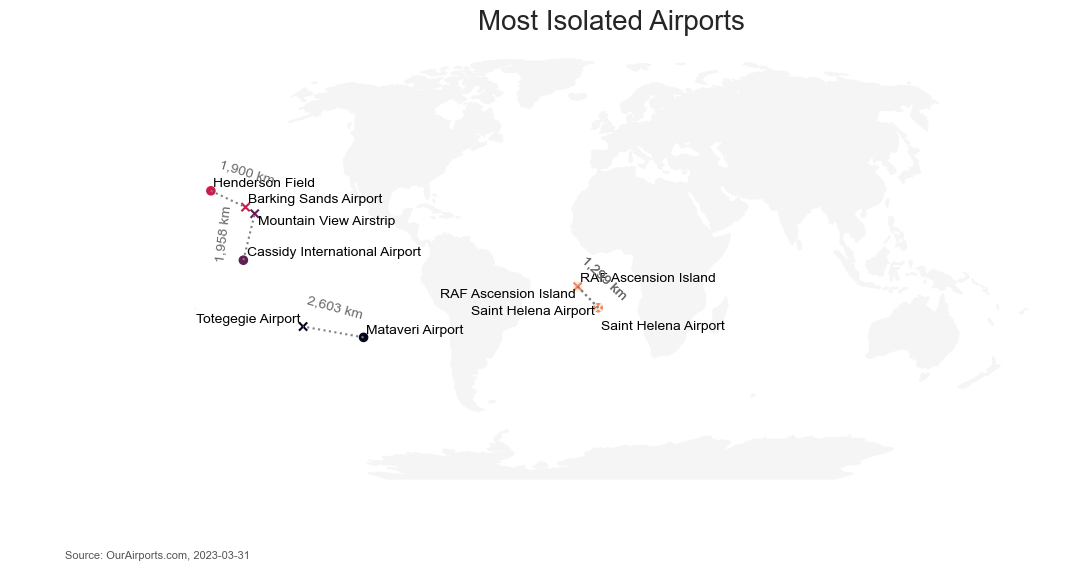

In [44]:
import adjustText as aT

# Setting up the base world map
fig, ax = plt.subplots(figsize=(13, 6))
gpd_world.plot(ax=ax, color=world_fc, edgecolor=world_fc)

# Setting up the airport data and geometries
gdf_pts = gpd.GeoDataFrame(
    sd_map,
    geometry=gpd.points_from_xy(sd_map['lon'], sd_map['lat']),
    crs=wgs84_proj)
gdf_pts.to_crs(rob_proj, inplace=True)

# Plotting the airports
gdf_pts.loc[gdf_pts['fr_to'] == 'fr'].plot(column='pair',
                                           ax=ax,
                                           marker='o', markersize=35,
                                           legend=False)

gdf_pts.loc[gdf_pts['fr_to'] == 'to', :].plot(column='pair',
                                              ax=ax,
                                              marker='x', markersize=35,
                                              legend=False)

# Setting up the line and label data
gdf_line = gpd.GeoDataFrame(
    line_map,
    geometry='geometry',
    crs=wgs84_proj)
gdf_line.to_crs(rob_proj, inplace=True)

gdf_lbls = gpd.GeoDataFrame(
    dlbl_map,
    geometry=gpd.points_from_xy(dlbl_map['lon'], dlbl_map['lat']),
    crs=wgs84_proj)
gdf_lbls.to_crs(rob_proj, inplace=True)

# Plotting the lines
gdf_line.plot(ax=ax, color='gray', linestyle=':')

# Labeling of airports
airport_lbls = []
for x, y, label in zip(gdf_pts.geometry.x, gdf_pts.geometry.y, gdf_pts['airport']):
    airport_lbls.append(plt.text(x, y, label, fontsize=10, color='black'))

aT.adjust_text(airport_lbls,
               force_static=(1, 1),
               force_explode=(0.1, 0.1),
               time_lim=1.0)

# Labeling of lines
line_lbls = []
for x, y, azi, label in zip(
        gdf_lbls.geometry.x, gdf_lbls.geometry.y, gdf_lbls['azi'], gdf_lbls['lbl']):

    line_lbls.append(
        plt.text(x, y, label,
                 horizontalalignment='center',
                 rotation=90-abs(azi), rotation_mode='anchor',
                 fontsize=10, color='dimgrey'))

# Formatting the plot
ax.set_axis_off()
ax.set_title("Most Isolated Airports",
             fontdict={'fontsize': '20', 'fontweight': '3'})
_ = ax.annotate("Source: OurAirports.com, "+today_date,
                xy=(0.05, .03),
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=8,
                color='#555555')


Yeah, so the labels don't exactly line up nicely, likely due to issues with using different coordinate reference systems

#### Simple bar plot showing the distances to nearest neighbour

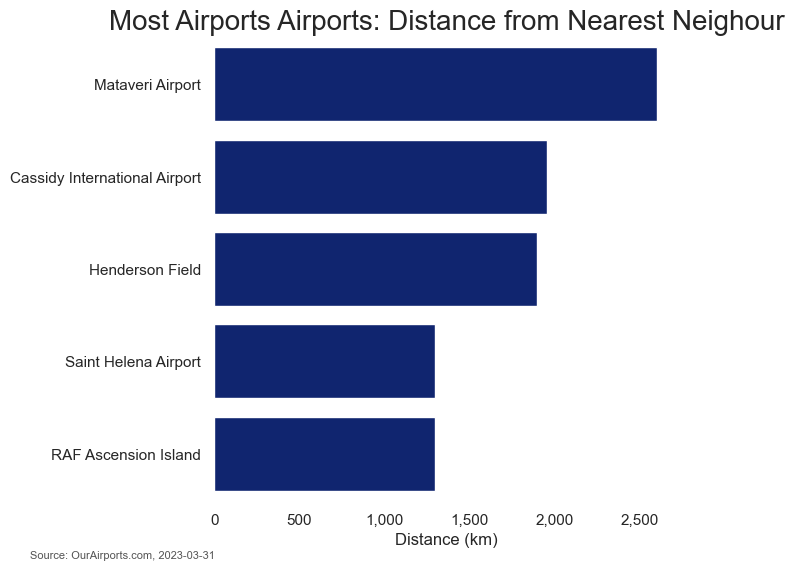

In [45]:
plot_data = simple_dist.sort_values('d_km', ascending=False).head(map_n)

fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x='d_km',
            y='airport_name_fr',
            data=plot_data,
            color='b')
sns.despine(bottom=True, left=True)

# Formatting the plot
ax.set_title("Most Airports Airports: Distance from Nearest Neighour",
             fontdict={'fontsize': '20', 'fontweight': '3'})
_ = ax.annotate("Source: OurAirports.com, "+today_date,
                xy=(0.05, .03),
                xycoords='figure fraction',
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=8,
                color='#555555')
ax.set(xlabel="Distance (km)",
       ylabel=None)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))


#### Airport vs. closest neighbour histogram

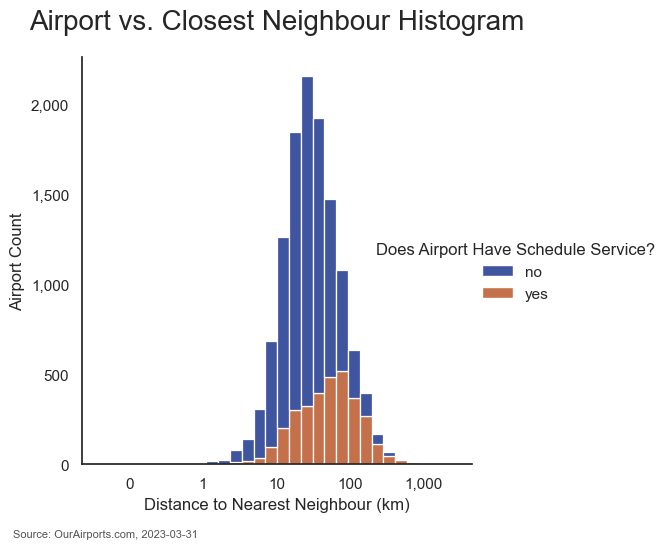

In [46]:
bins = 30

fg = sns.displot(
    data=simple_dist,
    x='d_km',
    hue='scheduled_service_fr',
    bins=bins,
    multiple='stack',
    log_scale=True,
    edgecolor=None,
    facet_kws={'legend_out': True},
)

fg.set_axis_labels(
    "Distance to Nearest Neighbour (km)",
    "Airport Count")


def xlbl_fmt(x, pos):
    # Formatting function for x axis tick labels
    return f"{x:,.0f}"


def ylbl_fmt(x, pos):
    # Formatting function for y axis tick labels
    return f"{x:,.0f}"


plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(xlbl_fmt))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(ylbl_fmt))

plt.gca().set_title("Airport vs. Closest Neighbour Histogram",
                    fontdict={'fontsize': '20', 'fontweight': '3'},
                    pad=20)
_ = plt.gca().annotate("Source: OurAirports.com, "+today_date,
                       xy=(0.02, .03),
                       xycoords='figure fraction',
                       horizontalalignment='left',
                       verticalalignment='top',
                       fontsize=8,
                       color='#555555')

fg._legend.set_title("Does Airport Have Schedule Service?")